In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [3]:
job_params = {    
    'notch_filt' :     None,
    'planes' :         n.arange(0,15),
    'n_ch_tif' : 15,
    'convert_plane_ids_to_channel_ids' : False,
    'fix_fastZ' : True,
    
    'n_init_files' :   3,
    'init_file_pool' : None,
    'init_file_sample_method': 'random',
    
    'subtract_crosstalk' : False,
    'override_crosstalk' : None,
    'crosstalk_n_planes' : 10, 
    
    'nonrigid' : True,
    'smooth_sigma' : 1.15,
    'maxregshift' : 0.15,
    'reg_filter_pcorr' : 1,
    'generate_sample_registered_bins' : False,

    'dtype' : n.float32,
    'tif_batch_size' : 1,
}



In [4]:
subjects_dir =   '/mnt/zaru-subjects/'
expt_info = { 
    'subject':         'AH010',
    'date' :          '2024-01-17',
    'expnum' :         [5],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

In [5]:
# Create the job
job = Job(savedir,exp_str, tifs = tifs,
          params=job_params, create=False, overwrite=True, verbosity = 3)

   Found and loaded params from /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/params.npy


In [6]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 4
job.params['init_n_frames'] = None

In [7]:
# %%time
# summary = job.run_init_pass()

In [8]:
summary = job.load_summary()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f78cffc9eb0>)

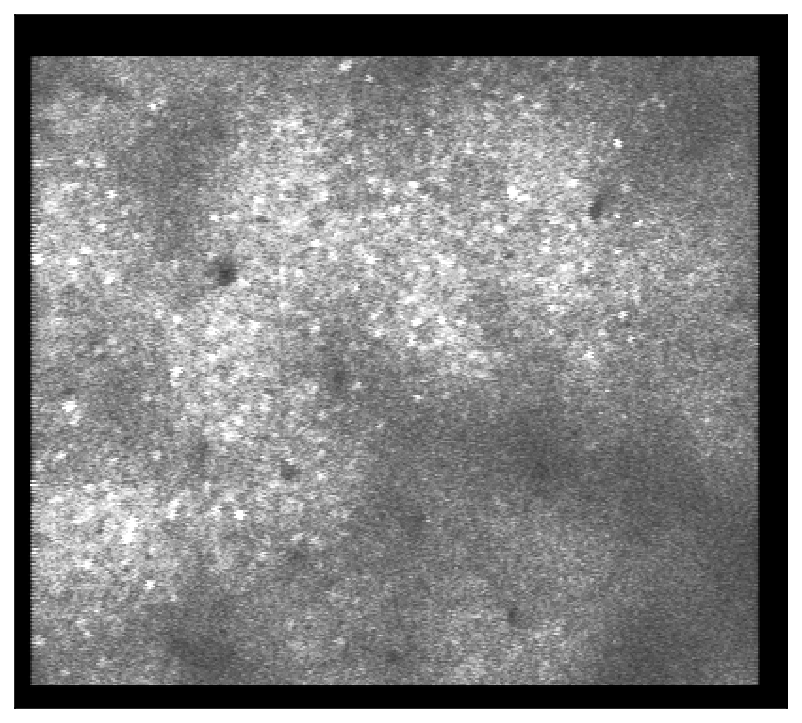

In [9]:
tfu.show_tif(summary['ref_img_3d'][8])

In [10]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [11]:
# %%time
# job.register_gpu()

In [12]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
im_full = mov_full[:,:200].mean(axis=1).compute()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f78ce058100>)

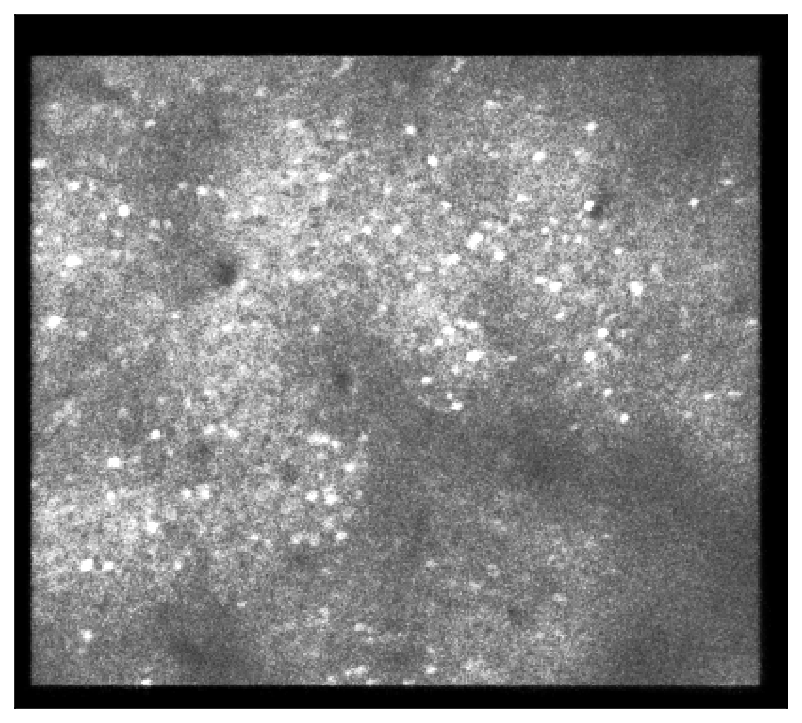

In [13]:
tfu.show_tif(im_full[8])

In [14]:
# Pick the parameters you want to sweep, and enter them in the tuples.
# It will do all combinations of parameters, so if you have many parameters it will be many combinations! 
job.params['t_batch_size'] = 300
params_to_sweep = {
    'intensity_thresh' : (0.1,),
    'n_svd_comp' : (50,), # if you have multiple values here, make sure you pass mov=svd_info
    'conv_filt_xy': (1.0,3.0, 5.0,),
    'npil_filt_xy': (5.0, 10.0, 15.0),
    'conv_filt_z' : (1.0,),
    'npil_filt_z' : (1.0,),
    'sdnorm_exp' : (1.0,)
}

sweep_summary = job.sweep_params(params_to_sweep, mov = mov_full,testing_dir_tag='sweep-nosvd',
                           do_vmap=True, all_combinations=True, n_test_iters = 1)
# use this to access older sweep results
# sweep_summary = n.load(os.path.join(job.dirs['sweep-full'], 'sweep_summary.npy'),allow_pickle=True).item()
job.vis_vmap_sweep(sweep_summary)

   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd with tag sweep-nosvd
   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd/sweep-nosvd-comb_00000 with tag sweep-nosvd-comb_00000
   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd/sweep-nosvd-comb_00001 with tag sweep-nosvd-comb_00001
   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd/sweep-nosvd-comb_00002 with tag sweep-nosvd-comb_00002
   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd/sweep-nosvd-comb_00003 with tag sweep-nosvd-comb_00003
   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd/sweep-nosvd-comb_00004 with tag sweep-nosvd-comb_00004
   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd/sweep-nosvd-comb_00005 with tag sweep-nosvd-comb_00005
   Created dir /mnt/md0/runs/AH010/2024-01-17/s3d-AH010_2024-01-17_5/sweep-nosvd/s

Viewer(camera=Camera(center=(0.0, 183.5, 204.5), zoom=2.455027173913043, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=10, ndisplay=2, last_used=9, range=((0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 3.0, 1.0), (0.0, 3.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 15.0, 1.0), (0.0, 368.0, 1.0), (0.0, 410.0, 1.0)), current_step=(0, 0, 0, 0, 0, 0, 0, 7, 183, 204), order=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), axis_labels=('intensity_thresh', 'n_svd_comp', 'conv_filt_xy', 'npil_filt_xy', 'conv_filt_z', 'npil_filt_z', 'sdnorm_exp', 'z', 'y', 'x')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'mean_img' at 0x7f78c43559d0>, <Image layer 'max_img' at 0x7f78cc1b9e50>, <Image layer 'Corrmap Sweep' at 0x7f78c4165be0>], help='use <2> for transform', status='Ready', tooltip=T

In [77]:
job.vis_vmap_sweep(sweep_summary)

[1, 1, 2, 3, 1, 1, 1]
(1, 1, 2, 3, 1, 1, 1, 15, 1102, 941)


Viewer(camera=Camera(center=(0.0, 550.5, 470.0), zoom=0.9491379310344827, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=10, ndisplay=2, last_used=9, range=((0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 2.0, 1.0), (0.0, 3.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 15.0, 1.0), (0.0, 1102.0, 1.0), (0.0, 941.0, 1.0)), current_step=(0, 0, 0, 0, 0, 0, 0, 7, 550, 470), order=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), axis_labels=('intensity_thresh', 'n_svd_comp', 'conv_filt_xy', 'npil_filt_xy', 'conv_filt_z', 'npil_filt_z', 'sdnorm_exp', 'z', 'y', 'x')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'mean_img' at 0x7f092197cf70>, <Image layer 'max_img' at 0x7f09218ca5e0>, <Image layer 'Corrmap Sweep' at 0x7f09218d1520>], help='use <2> for transform', status='Ready', tooltip

In [106]:

job.params['t_batch_size'] = 400
job.params['intensity_thresh'] = (0.1)
job.params['n_svd_comp'] = (50), # if you have multiple values here, make sure you pass mov=svd_info
job.params['conv_filt_xy']= 2.5
job.params['npil_filt_xy']= 15.0
job.params['conv_filt_z'] = 1.0
job.params['npil_filt_z'] = 1.0
job.params['sdnorm_exp'] = 1.0

In [107]:
job.calculate_corr_map(mov_full)

   Updated main params file
   Created dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/mov_sub with tag mov_sub
   Saving mov_sub to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/mov_sub
   Using conv_filt: gaussian, 1.00, 2.50
   Using np_filt: unif, 1.00, 15.00
   Created files and dirs for 1 batches
      Running batch 1 of 1
         Will process 313 frames (0-313, t_batch_size: 400)
      Loaded and swapped, idx 0 to 313
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
   Calculated corr map in 43.85 seconds
      Saving to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000


((array([[[0.        , 0.        , 0.        , ..., 1.28376966,
           1.31376819, 1.31376819],
          [0.        , 0.        , 0.        , ..., 1.28376966,
           1.31376819, 1.31376819],
          [0.        , 0.        , 0.        , ..., 1.27431526,
           1.31361761, 1.31361761],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
  
         [[0.        , 0.        , 0.        , ..., 0.66236551,
           0.69285873, 0.69285873],
          [0.        , 0.        , 0.        , ..., 0.66236551,
           0.69285873, 0.69285873],
          [0.        , 0.        , 0.        , ..., 0.7159002 ,
           0.78412234, 0.78412234],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
  

In [108]:
vmap = job.load_iter_results(-1)['vmap']

   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000


In [114]:
napari.view_image(vmap)

Viewer(camera=Camera(center=(0.0, 397.5, 302.5), zoom=1.4304922250836567, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(7.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 15.0, 1.0), (0.0, 796.0, 1.0), (0.0, 606.0, 1.0)), current_step=(7, 397, 302), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'vmap' at 0x7f5866d05220>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f5b6ef8faf0>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [115]:
%%time
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = 2.65

job.params['activity_thresh'] = 10.0
job.params['percentile'] = 98.0
job.params['extend_thresh'] = 0.15
job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch
combined_dir = job.patch_and_detect(combined_name='combined-full')

   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
63 blocks with overlap (42 without, 1.50x increase)
63 blocks with overlap (42 without, 1.50x increase)
   Detecting from patch: 0/63
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection with tag detection
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0000 with tag patch-0000
   Running cell detection on patch 0000 at /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0000, max 10000 iters
   Patch bounds are [ 0 15], [  0 120], [  0 120]
   Cell center bounds are [ 0 15], [  0 102], [  0 100]
   Time bounds are (None, None)
mov_sub
   Loading 0.25 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p

   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0005
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 08, 071, 480, peak: 4.661, thresh: 2.983, 18 frames, 219 pixels
      Added cell 2 at 06, 058, 455, peak: 4.151, thresh: 2.891, 18 frames, 284 pixels
      Added cell 3 at 07, 047, 464, peak: 3.975, thresh: 3.138, 27 frames, 131 pixels
      Added cell 4 at 04, 091, 478, peak: 3.959, thresh: 3.662, 10 frames, 134 pixels
      Added cell 5 at 02, 025, 502, peak: 3.605, thresh: 2.972, 16 frames, 105 pixels
      Added cell 6 at 08, 095, 503, peak: 3.563, thresh: 4.506, 10 frames, 94 pixels
      Added cell 7 at 09, 085, 492, peak: 3.557, thresh: 3.460, 17 frames, 155 pixels
     

      Added cell 5 at 03, 181, 167, peak: 3.171, thresh: 3.155, 10 frames, 183 pixels
      Added cell 6 at 03, 184, 172, peak: 2.970, thresh: 2.929, 19 frames, 200 pixels
      Iter 0002: peak is too small  - ending extraction
   Found 6 cells in 2 iterations
   Saving cells to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0008/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0008/iscell.npy
   Detecting from patch: 9/63
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection with tag detection
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0009 with tag patch-0009
   Running cell detection on patch 0009 at /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0009, max 10000 iters
   Patch bounds are [ 0 15], [ 84 204], [162 282]
   Cell center bounds are [ 0 15], [102 186], [181 262]
 

   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0012
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 07, 185, 481, peak: 6.266, thresh: 3.394, 41 frames, 213 pixels
      Added cell 2 at 08, 135, 483, peak: 6.058, thresh: 3.883, 40 frames, 237 pixels
      Added cell 3 at 04, 125, 472, peak: 5.697, thresh: 4.136, 32 frames, 142 pixels
      Added cell 4 at 09, 185, 480, peak: 4.682, thresh: 3.501, 40 frames, 198 pixels
      Added cell 5 at 08, 126, 501, peak: 4.495, thresh: 3.468, 18 frames, 195 pixels
      Added cell 6 at 05, 185, 481, peak: 4.290, thresh: 2.516, 47 frames, 253 pixels
      Added cell 7 at 01, 106, 462, peak: 4.239, thresh: 3.823, 29 frames, 151 pixels
    

      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0014
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
      Iter 0000: peak is too small  - ending extraction
   Found 0 cells in 0 iterations
   Saving cells to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0014/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0014/iscell.npy
   Detecting from patch: 15/63
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection with tag detection
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0015 with tag patch-0015
   Running cell detection on patch 0015 at /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0015, max 10000 iters
   Patch bounds are [ 0 1

      Added cell 17 at 05, 228, 368, peak: 2.899, thresh: 3.053, 13 frames, 139 pixels
      Added cell 18 at 04, 210, 379, peak: 2.809, thresh: 2.533, 17 frames, 195 pixels
      Added cell 19 at 01, 208, 410, peak: 2.808, thresh: 2.153, 10 frames, 36 pixels
      Added cell 20 at 10, 214, 397, peak: 2.773, thresh: 2.451, 19 frames, 230 pixels
      Added cell 21 at 02, 197, 408, peak: 2.758, thresh: 2.040, 12 frames, 84 pixels
      Added cell 22 at 03, 210, 411, peak: 2.669, thresh: 1.963, 9 frames, 47 pixels
      Iter 0003: peak is too small  - ending extraction
   Found 22 cells in 3 iterations
   Saving cells to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0018/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0018/iscell.npy
   Detecting from patch: 19/63
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection with tag detection
      Found

      Added cell 33 at 03, 259, 589, peak: 3.416, thresh: 3.243, 16 frames, 124 pixels
      Added cell 34 at 03, 210, 598, peak: 3.399, thresh: 2.377, 8 frames, 261 pixels
      Added cell 35 at 05, 186, 592, peak: 3.390, thresh: 0.142, 24 frames, 287 pixels
      Added cell 36 at 04, 209, 559, peak: 3.362, thresh: 2.669, 14 frames, 105 pixels
      Added cell 37 at 04, 246, 596, peak: 3.352, thresh: 0.179, 75 frames, 111 pixels
      Added cell 38 at 01, 263, 528, peak: 3.327, thresh: 3.035, 23 frames, 113 pixels
      Added cell 39 at 06, 229, 589, peak: 3.321, thresh: 0.207, 31 frames, 320 pixels
      Added cell 40 at 07, 216, 586, peak: 3.238, thresh: 1.910, 11 frames, 269 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 14, 216, 571, peak: 3.219, thresh: 0.336, 11 frames, 83 pixels
      Added cell 42 at 07, 255, 586, peak: 3.196, thresh: 1.723, 13 frames, 256 pixels
      Added cell 43 at 10, 189, 579, peak: 3.149, thresh: 0.987, 15 frames, 114 pixels
   

   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0024
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 04, 337, 278, peak: 4.802, thresh: 3.551, 36 frames, 159 pixels
      Added cell 2 at 05, 317, 278, peak: 4.196, thresh: 3.191, 30 frames, 154 pixels
      Added cell 3 at 07, 336, 332, peak: 4.118, thresh: 3.730, 22 frames, 86 pixels
      Added cell 4 at 08, 316, 335, peak: 3.683, thresh: 3.103, 15 frames, 126 pixels
      Added cell 5 at 05, 313, 268, peak: 3.446, thresh: 3.125, 16 frames, 131 pixels
      Added cell 6 at 09, 295, 337, peak: 3.078, thresh: 3.134, 11 frames, 95 pixels
      Added cell 7 at 09, 351, 264, peak: 2.923, thresh: 2.744, 12 frames, 189 pixels
      

      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0027
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 03, 338, 525, peak: 5.020, thresh: 4.516, 23 frames, 134 pixels
      Added cell 2 at 03, 279, 548, peak: 4.347, thresh: 3.846, 22 frames, 134 pixels
      Added cell 3 at 04, 278, 596, peak: 4.311, thresh: 0.164, 30 frames, 302 pixels
      Added cell 4 at 04, 286, 597, peak: 4.028, thresh: 0.166, 31 frames, 306 pixels
      Added cell 5 at 03, 316, 539, peak: 3.992, thresh: 4.446, 10 frames, 190 pixels
      Added cell 6 at 04, 310, 596, peak: 3.942, thresh: 0.156, 37 frames, 284 pixels
      Added cell 7 at 04, 273, 540, peak: 3.888, thresh: 3.647, 17 frames, 168 pixels
      Added cell 8 at 06, 310, 525, peak: 3.830, thresh: 3.741, 16 frames, 141 pixels
   Iter 0001: run

   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 05, 378, 181, peak: 5.643, thresh: 3.803, 20 frames, 278 pixels
      Added cell 2 at 02, 418, 235, peak: 5.399, thresh: 4.467, 33 frames, 135 pixels
      Added cell 3 at 05, 364, 244, peak: 4.262, thresh: 3.700, 26 frames, 100 pixels
      Added cell 4 at 08, 425, 220, peak: 3.971, thresh: 3.923, 7 frames, 166 pixels
      Added cell 5 at 02, 403, 199, peak: 3.928, thresh: 4.490, 20 frames, 116 pixels
      Added cell 6 at 07, 370, 235, peak: 3.591, thresh: 2.718, 22 frames, 219 pixels
      Added cell 7 at 00, 367, 258, peak: 3.588, thresh: 3.102, 18 frames, 87 pixels
      Added cell 8 at 07, 433, 241, peak: 3.580, thresh: 2.889, 21 frames, 221 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 08, 356, 209, peak: 3.449, thresh: 3.831, 13 frames, 111 pixels
      Added cell 10 at 03, 390, 244, peak: 3.392, thresh: 3.676, 10 frames, 167 pixels
      Added cell 11 at 04, 396, 187, peak: 3.386, thresh:

      Added cell 17 at 03, 369, 399, peak: 3.206, thresh: 3.125, 11 frames, 160 pixels
      Added cell 18 at 08, 389, 364, peak: 3.063, thresh: 2.425, 13 frames, 251 pixels
      Added cell 19 at 02, 397, 351, peak: 3.054, thresh: 2.884, 18 frames, 132 pixels
      Added cell 20 at 06, 398, 386, peak: 3.032, thresh: 3.225, 18 frames, 132 pixels
      Added cell 21 at 09, 369, 374, peak: 2.889, thresh: 3.026, 17 frames, 151 pixels
      Added cell 22 at 02, 367, 423, peak: 2.831, thresh: 2.197, 22 frames, 215 pixels
      Added cell 23 at 06, 423, 383, peak: 2.823, thresh: 2.626, 14 frames, 205 pixels
      Added cell 24 at 12, 393, 355, peak: 2.758, thresh: 2.635, 16 frames, 87 pixels
   Iter 0003: running 04 ROIs in parallel
      Added cell 25 at 00, 419, 371, peak: 2.755, thresh: 2.602, 9 frames, 113 pixels
      Added cell 26 at 06, 393, 394, peak: 2.723, thresh: 2.885, 12 frames, 125 pixels
      Added cell 27 at 04, 413, 381, peak: 2.686, thresh: 2.694, 17 frames, 282 pixels
   

   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0035
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 07 ROIs in parallel
      Added cell 1 at 08, 518, 025, peak: 4.168, thresh: 3.046, 28 frames, 169 pixels
      Added cell 2 at 07, 473, 026, peak: 3.436, thresh: 2.535, 25 frames, 173 pixels
      Added cell 3 at 07, 498, 053, peak: 3.047, thresh: 2.931, 15 frames, 159 pixels
      Added cell 4 at 07, 514, 019, peak: 2.790, thresh: 3.129, 11 frames, 126 pixels
      Added cell 5 at 06, 498, 018, peak: 2.750, thresh: 2.603, 5 frames, 22 pixels
      Added cell 6 at 02, 512, 029, peak: 2.707, thresh: 1.400, 15 frames, 47 pixels
      Added cell 7 at 08, 466, 035, peak: 2.657, thresh: 2.724, 8 frames, 82 pixels
      Ite

   Found 10 cells in 2 iterations
   Saving cells to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0039/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0039/iscell.npy
   Detecting from patch: 40/63
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection with tag detection
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0040 with tag patch-0040
   Running cell detection on patch 0040 at /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0040, max 10000 iters
   Patch bounds are [ 0 15], [422 542], [405 525]
   Cell center bounds are [ 0 15], [440 524], [424 505]
   Time bounds are (None, None)
mov_sub
   Loading 0.25 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell

   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0043
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
      Iter 0000: peak is too small  - ending extraction
   Found 0 cells in 0 iterations
   Saving cells to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0043/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0043/iscell.npy
   Detecting from patch: 44/63
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection with tag detection
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0044 with tag patch-0044
   Running cell detection on patch 0044 at /mnt/md0/runs/s3d-AH0

      Added cell 1 at 14, 567, 572, peak: 3.904, thresh: 0.166, 28 frames, 60 pixels
      Added cell 2 at 09, 556, 582, peak: 3.534, thresh: 0.164, 43 frames, 136 pixels
      Added cell 3 at 14, 556, 573, peak: 3.423, thresh: 0.013, 79 frames, 95 pixels
      Added cell 4 at 14, 608, 573, peak: 3.389, thresh: 0.407, 17 frames, 198 pixels
      Added cell 5 at 14, 590, 573, peak: 3.173, thresh: -0.009, 24 frames, 84 pixels
      Added cell 6 at 08, 584, 584, peak: 3.082, thresh: 3.272, 12 frames, 271 pixels
      Added cell 7 at 04, 533, 596, peak: 3.030, thresh: 0.544, 28 frames, 266 pixels
      Added cell 8 at 14, 538, 572, peak: 3.004, thresh: 0.714, 15 frames, 187 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 09, 582, 581, peak: 3.015, thresh: 2.745, 9 frames, 110 pixels
      Added cell 10 at 07, 530, 587, peak: 2.952, thresh: 2.426, 16 frames, 219 pixels
      Added cell 11 at 10, 525, 536, peak: 2.944, thresh: 2.766, 14 frames, 97 pixels
      Added ce

      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0051
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 02, 661, 243, peak: 6.291, thresh: 3.937, 47 frames, 186 pixels
      Added cell 2 at 09, 656, 249, peak: 5.686, thresh: 4.788, 32 frames, 118 pixels
      Added cell 3 at 08, 642, 236, peak: 5.604, thresh: 3.840, 45 frames, 128 pixels
      Added cell 4 at 06, 667, 253, peak: 4.842, thresh: 3.662, 37 frames, 113 pixels
      Added cell 5 at 05, 662, 214, peak: 4.752, thresh: 4.364, 22 frames, 205 pixels
      Added cell 6 at 06, 643, 224, peak: 4.653, thresh: 3.562, 30 frames, 140 pixels
      Added cell 7 at 03, 626, 219, peak: 4.392, thresh: 3.112, 32 frames, 296 pixels
      Added cell 8 at 02, 617, 238, peak: 4.138, thresh: 2.886, 41 frames, 234 pixels
   Iter 0001: run

   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0053
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 08, 687, 346, peak: 6.643, thresh: 3.260, 64 frames, 196 pixels
      Added cell 2 at 03, 622, 361, peak: 6.224, thresh: 3.482, 74 frames, 222 pixels
      Added cell 3 at 09, 678, 381, peak: 5.707, thresh: 5.243, 21 frames, 163 pixels
      Added cell 4 at 08, 670, 366, peak: 5.252, thresh: 3.707, 34 frames, 164 pixels
      Added cell 5 at 10, 630, 364, peak: 5.013, thresh: 3.557, 46 frames, 131 pixels
      Added cell 6 at 02, 630, 363, peak: 4.999, thresh: 3.416, 74 frames, 223 pixels
      Added cell 7 at 10, 687, 348, peak: 4.902, thresh: 3.206, 75 frames, 184 pixels
    

      Added cell 17 at 05, 654, 592, peak: 2.740, thresh: 3.372, 10 frames, 44 pixels
      Added cell 18 at 02, 688, 601, peak: 2.697, thresh: 2.499, 26 frames, 163 pixels
      Added cell 19 at 10, 639, 579, peak: 2.673, thresh: 3.737, 7 frames, 24 pixels
      Added cell 20 at 08, 666, 585, peak: 2.666, thresh: 1.757, 12 frames, 155 pixels
      Added cell 21 at 05, 637, 592, peak: 2.654, thresh: 2.699, 10 frames, 127 pixels
      Iter 0003: peak is too small  - ending extraction
   Found 21 cells in 3 iterations
   Saving cells to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0055/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0055/iscell.npy
   Detecting from patch: 56/63
   Updated main params file
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection with tag detection
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0056 wit

   Loaded
   Loading from /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/iters/batch0000
      Movie shape: (313, 15, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0058
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.650 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 05, 721, 253, peak: 7.839, thresh: 3.591, 64 frames, 241 pixels
      Added cell 2 at 03, 708, 235, peak: 5.639, thresh: 4.006, 51 frames, 138 pixels
      Added cell 3 at 07, 735, 248, peak: 5.635, thresh: 4.424, 34 frames, 126 pixels
      Added cell 4 at 04, 730, 232, peak: 5.620, thresh: 4.083, 31 frames, 187 pixels
      Added cell 5 at 07, 722, 252, peak: 5.397, thresh: 2.876, 71 frames, 221 pixels
      Added cell 6 at 06, 702, 200, peak: 4.898, thresh: 4.478, 32 frames, 74 pixels
      Added cell 7 at 07, 694, 261, peak: 4.629, thresh: 3.773, 23 frames, 150 pixels
     

      Added cell 33 at 08, 748, 271, peak: 3.409, thresh: 3.773, 10 frames, 240 pixels
      Added cell 34 at 07, 742, 289, peak: 3.397, thresh: 2.095, 41 frames, 156 pixels
      Added cell 35 at 11, 783, 321, peak: 3.394, thresh: 3.852, 13 frames, 62 pixels
      Added cell 36 at 06, 730, 301, peak: 3.311, thresh: 2.786, 31 frames, 175 pixels
      Added cell 37 at 03, 766, 282, peak: 3.309, thresh: 2.037, 37 frames, 248 pixels
      Added cell 38 at 07, 750, 324, peak: 3.298, thresh: 1.922, 12 frames, 43 pixels
      Added cell 39 at 01, 758, 269, peak: 3.297, thresh: 0.489, 33 frames, 186 pixels
      Added cell 40 at 07, 725, 337, peak: 3.294, thresh: 2.516, 22 frames, 267 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 10, 718, 326, peak: 3.243, thresh: 2.667, 31 frames, 74 pixels
      Added cell 42 at 09, 733, 317, peak: 3.097, thresh: 3.370, 16 frames, 109 pixels
      Added cell 43 at 09, 738, 340, peak: 3.094, thresh: 2.042, 29 frames, 273 pixels
    

      Added cell 49 at 02, 746, 408, peak: 3.155, thresh: 3.052, 12 frames, 262 pixels
      Added cell 50 at 07, 727, 371, peak: 3.138, thresh: 2.193, 15 frames, 258 pixels
      Added cell 51 at 09, 716, 349, peak: 3.118, thresh: 3.542, 18 frames, 103 pixels
      Added cell 52 at 06, 779, 356, peak: 3.087, thresh: 0.683, 52 frames, 167 pixels
      Added cell 53 at 03, 767, 404, peak: 3.029, thresh: 0.383, 43 frames, 256 pixels
      Added cell 54 at 07, 707, 401, peak: 3.002, thresh: 2.382, 21 frames, 186 pixels
      Added cell 55 at 06, 779, 343, peak: 3.000, thresh: 0.905, 41 frames, 255 pixels
      Added cell 56 at 09, 739, 401, peak: 2.997, thresh: 2.668, 16 frames, 115 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 02, 762, 399, peak: 3.012, thresh: 1.606, 42 frames, 96 pixels
      Added cell 58 at 11, 794, 361, peak: 2.994, thresh: 0.645, 34 frames, 229 pixels
      Added cell 59 at 03, 709, 365, peak: 2.957, thresh: 2.799, 18 frames, 145 pixels
  

      Added cell 17 at 00, 753, 551, peak: 3.367, thresh: 5.391, 7 frames, 56 pixels
      Added cell 18 at 03, 719, 598, peak: 3.346, thresh: 2.032, 19 frames, 262 pixels
      Added cell 19 at 09, 782, 581, peak: 3.344, thresh: 3.495, 15 frames, 191 pixels
      Added cell 20 at 00, 753, 543, peak: 3.340, thresh: 4.436, 20 frames, 256 pixels
      Added cell 21 at 10, 771, 580, peak: 3.337, thresh: 3.128, 12 frames, 117 pixels
      Added cell 22 at 01, 758, 562, peak: 3.323, thresh: 3.799, 20 frames, 262 pixels
      Added cell 23 at 04, 761, 595, peak: 3.314, thresh: 3.457, 8 frames, 223 pixels
      Added cell 24 at 05, 707, 593, peak: 3.257, thresh: 0.304, 43 frames, 210 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 01, 758, 600, peak: 3.239, thresh: 1.378, 8 frames, 187 pixels
      Added cell 26 at 03, 766, 587, peak: 3.238, thresh: 1.821, 24 frames, 209 pixels
      Added cell 27 at 03, 766, 536, peak: 3.171, thresh: 3.139, 20 frames, 260 pixels
     

      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0035 with tag detection-patch-0035
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0036 with tag detection-patch-0036
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0037 with tag detection-patch-0037
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0038 with tag detection-patch-0038
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0039 with tag detection-patch-0039
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0040 with tag detection-patch-0040
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0041 with tag detection-patch-0041
      Found dir /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/patch-0042 with tag detection-patch-0042
      Fo

In [117]:
outputs = ui.load_outputs(combined_dir, load_traces=False)
v,layers = ui.create_ui(outputs)
ui.add_callbacks_to_ui(v,layers,outputs,savedir=combined_dir,overwrite=True)

Cells
('vmap_peak', (2.6505692, 3.946812725067139), 'peak_val', <function add_curation_sliders.<locals>.<lambda> at 0x7f5a06666940>)
Updating cell 46
1087, 1087 cells valid
Cells
Updating cell 41
1086, 1086 cells valid
Cells
Updating cell 161
1085, 1085 cells valid
Cells
Updating cell 144
1084, 1084 cells valid
Cells
Updating cell 158
1083, 1083 cells valid
Cells
Updating cell 142
1082, 1082 cells valid
Cells
Updating cell 142
1083, 1083 cells valid
Cells
Updating cell 142
1082, 1082 cells valid
Cells
Updating cell 275
1081, 1081 cells valid
Cells
Updating cell 275
1082, 1082 cells valid
Cells
Updating cell 275
1081, 1081 cells valid
Cells
Updating cell 275
1082, 1082 cells valid
Cells
Updating cell 275
1081, 1081 cells valid
Cells
Updating cell 248
1080, 1080 cells valid
Cells
Updating cell 275
1081, 1081 cells valid
Cells
Updating cell 275
1080, 1080 cells valid
Cells
Updating cell 275
1081, 1081 cells valid
Cells
Updating cell 275
1080, 1080 cells valid
Cells
Updating cell 274
1079,

In [118]:
job.compute_npil_masks(combined_dir)

'/mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/combined-full'

In [122]:
traces = job.extract_and_deconvolve(stats_dir = combined_dir, mov=mov_full, crop=False)

   Updated main params file
   Movie shape: (15, 313, 796, 606)
1092
   Extracting 1092 valid cells, and saving cell flags to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/combined-full/iscell_extracted.npy
   Extracting activity
Will extract in 1 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/combined-full
Extracting batch 0000 of 0001
Batch size: 8 GB
   Deconvolving
   Saving to /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/combined-full


In [123]:
combined_dir = job.dirs['detection-combined-full']

In [124]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
v,layers = ui.create_ui(outputs)
ui.add_callbacks_to_ui(v,layers,outputs,savedir=combined_dir)

Found old curated iscell with 1063 of 1092 marked as cells
Saving old iscell_curated to backup path /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/combined-full/iscell_curated_old_17-01-24_13-09-52.npy
Cells
Found old curated + slider-ed iscell with 1063 of 1092 marked as cells
Saving old iscell_curated to backup path /mnt/md0/runs/s3d-AH010_2024-01-16-2umpix3p9fps-laser70p/detection/combined-full/iscell_curated_slider_old_17-01-24_13-09-52.npy
('vmap_peak', (2.6505692, 3.946812725067139), 'peak_val', <function add_curation_sliders.<locals>.<lambda> at 0x7f57d5836160>)
